### Importar librerías

In [715]:
import pandas as pd
import sklearn.discriminant_analysis as da
import sklearn.neighbors as nb
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, auc, classification_report, roc_curve

## Cargar Dataframe

In [716]:
df = pd.read_csv("https://raw.githubusercontent.com/opcruz/datasets/main/Weekly.csv", sep=",")
df.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


In [717]:
print('Tamaño de la muestra:', df.shape[0])

Tamaño de la muestra: 1089


### Información estadística

In [718]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,1089.0,2000.048669,6.033182,1990.000000,1995.000000,2000.00000,2005.000000,2010.000000
Lag1,1089.0,0.150585,2.357013,-18.195000,-1.154000,0.24100,1.405000,12.026000
Lag2,1089.0,0.151079,2.357254,-18.195000,-1.154000,0.24100,1.409000,12.026000
Lag3,1089.0,0.147205,2.360502,-18.195000,-1.158000,0.24100,1.409000,12.026000
Lag4,1089.0,0.145818,2.360279,-18.195000,-1.158000,0.23800,1.409000,12.026000
Lag5,1089.0,0.139893,2.361285,-18.195000,-1.166000,0.23400,1.405000,12.026000
Volume,1089.0,1.574618,1.686636,0.087465,0.332022,1.00268,2.053727,9.328214
Today,1089.0,0.149899,2.356927,-18.195000,-1.154000,0.24100,1.405000,12.026000


### Matriz de correlación entre los predictores

In [719]:
df.drop(columns=['Direction']).corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,-0.032289,-0.033390,-0.030006,-0.031128,-0.030519,0.841942,-0.032460
Lag1,-0.032289,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951,-0.075032
Lag2,-0.033390,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513,0.059167
Lag3,-0.030006,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288,-0.071244
Lag4,-0.031128,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075,-0.007826
Lag5,-0.030519,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517,0.011013
Volume,0.841942,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000,-0.033078
Today,-0.032460,-0.075032,0.059167,-0.071244,-0.007826,0.011013,-0.033078,1.000000


Como se puede apreciar, los valores de correlación entre las variables **lag*** y **today** son cercanos a cero. Esto significa que parece haber poca correlación entre los rendimientos de hoy y los días anteriores. La única correlación importante es entre **Year** y **Volumen**.


In [720]:
df_down = df[df['Direction'] == 'Down']
df_up = df[df['Direction'] == 'Up']

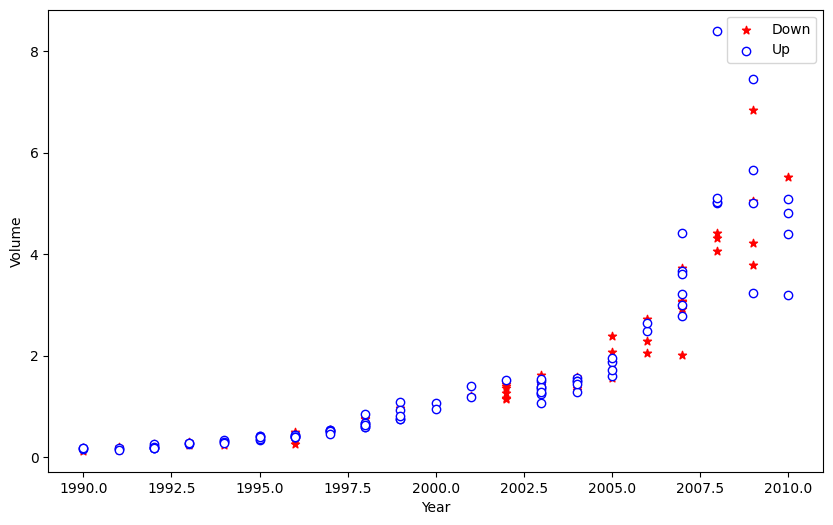

In [721]:
plt.figure(1, figsize=(10, 6))
# considerar una muestra aleatoria del 15 por ciento
df_down_15 = df_down.sample(frac=0.15)
df_up_15 = df_up.sample(frac=0.15)
plt.clf()  # clear figure
plt.xlabel('Year')
plt.ylabel('Volume')
plt.scatter(df_down_15['Year'], df_down_15['Volume'], color='red', marker='*', label="Down")
plt.scatter(df_up_15['Year'], df_up_15['Volume'], facecolors='white', edgecolors='blue', label="Up")
plt.legend()
plt.show()

Al graficar los datos, vemos que el volumen aumenta con el tiempo. En otras palabras, el número medio de acciones negociadas diariamente aumentó de 1990 a 2010.

In [722]:
df['direction_dummy'] = df['Direction'].factorize()[0]

In [723]:
df.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,direction_dummy
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down,0
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down,0
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up,1
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up,1
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up,1


Down -> 0
UP   -> 1

## Regresión Logística

In [769]:
X_train = df[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']]
X_test = X_train
y_train = df[['direction_dummy']]
y_test = y_train

print("Datos originales:", df.shape[0])
print("Datos para el entrenamiento:", X_train.shape[0])

Datos originales: 1089
Datos para el entrenamiento: 1089


### Aplicar Regresión Logística

In [770]:
# Añadir una columna de unos para el término independiente
X_train1 = sm.add_constant(X_train)
# Ajustar el modelo
model = sm.Logit(y_train, X_train1).fit()
# Imprimir los resultados
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.682441
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:        direction_dummy   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1082
Method:                           MLE   Df Model:                            6
Date:                Sun, 09 Apr 2023   Pseudo R-squ.:                0.006580
Time:                        18:02:15   Log-Likelihood:                -743.18
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                    0.1313
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.

Si nos fijamos en los valores de probabilidad (P > |z|) podemos apreciar que el predictor estadísticamente más significativo es **lag2**, despúes le sigue **lag1**. Este último no posee un valor por debajo de 0.05, por lo que no hay pruebas claras de una asociación real entre **Lag1** y **Direction**.
El coeficiente positivo del predictor **lag2** sugiere que si el mercado tuvo un rendimiento positivo hace dos días, es más probable que suba hoy.

### Matriz de confusión

In [726]:
decision_prob = 0.5

X_test1 = sm.add_constant(X_test)
predictions_prob = model.predict(X_test1)
predictions = predictions_prob > decision_prob

df_ = pd.DataFrame({'True values': y_test.values.ravel(), 'Predicted values': predictions})
df_.replace(to_replace={True: 1, False: 0}, inplace=True)

df_.replace(to_replace={1: 'Up', 0: 'Down'}, inplace=True)
df_.groupby(['Predicted values', 'True values']).size().unstack('True values')


True values,Down,Up
Predicted values,,
Down,54,48
Up,430,557


Los elementos diagonales de la matriz de confusión indican predicciones correctas, mientras que los no diagonales representan predicciones incorrectas.

#### Métricas

In [727]:
matrix_t = confusion_matrix(y_test, predictions).T

# imprimir las métricas
print('Accuracy:', round(accuracy_score(y_test, predictions), 3))
print('AUC:', round(roc_auc_score(y_test, predictions), 3))
print('Precision:', round(precision_score(y_test, predictions), 3))
print('Recall:', round(recall_score(y_test, predictions), 3))
print('Specificity:', round(matrix_t[0][0] / matrix_t.T[0].sum(), 3))

Accuracy: 0.561
AUC: 0.516
Precision: 0.564
Recall: 0.921
Specificity: 0.112


In [728]:
print(classification_report(y_test, predictions, digits=3))

              precision    recall  f1-score   support

           0      0.529     0.112     0.184       484
           1      0.564     0.921     0.700       605

    accuracy                          0.561      1089
   macro avg      0.547     0.516     0.442      1089
weighted avg      0.549     0.561     0.471      1089



- A primera vista, parece que el modelo de regresión logística funciona un poco mejor que la clasificación aleatoria.
- Se puede ver como el modelo posee un alto valor de sensibilidad (**Recall**), pero sacrifica en especificidad (**Specificity**).
- El modelo clasifica incorrectamente en la mayoría de las ocasiones la dirección de bajada (**Down**) como subida (**Up**).

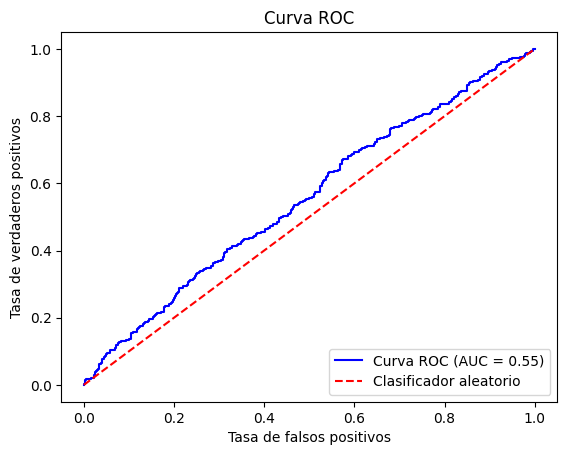

In [729]:
# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, predictions_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Clasificador aleatorio')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

A pesar de que el valor de **AUC** es mayor que el del **Clasificador aleatorio**, no llega a ser muy significativo y los resultados no son muy buenos. Más teniendo en cuenta que el conjunto de entrenamiento y prueba utilizado es el mismo.

### Comparación de diferentes modelos

In [730]:
train = df[df['Year'] < 2009]
test = df[df['Year'] >= 2009]
train_X = train['Lag2']
train_y = train['direction_dummy']
test_X = test['Lag2']
test_y = test['direction_dummy']
train_X_reshaped = train_X.values.reshape(-1, 1)
test_X_reshaped = test_X.values.reshape(-1, 1)

test_y = test_y.to_numpy()

#### Regresión Logística

In [731]:
# Añadir una columna de unos para el término independiente
train_X1 = sm.add_constant(train_X)
# Ajustar el modelo
model2 = sm.Logit(train_y, train_X1).fit()
# Imprimir los resultados
print(model2.summary())

Optimization terminated successfully.
         Current function value: 0.685555
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:        direction_dummy   No. Observations:                  985
Model:                          Logit   Df Residuals:                      983
Method:                           MLE   Df Model:                            1
Date:                Sun, 09 Apr 2023   Pseudo R-squ.:                0.003076
Time:                        18:01:01   Log-Likelihood:                -675.27
converged:                       True   LL-Null:                       -677.35
Covariance Type:            nonrobust   LLR p-value:                   0.04123
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2033      0.064      3.162      0.002       0.077       0.329
Lag2           0.0581      0.

In [732]:
test_X1 = sm.add_constant(test_X)
y_prob = model2.predict(test_X1)
y_prob = y_prob.to_numpy()

#### Matriz de confusión

In [733]:
decision_prob = 0.5

y_predicted = y_prob > decision_prob
df_ = pd.DataFrame({'True default status': test_y,
                    'Predicted default status': y_predicted})

# matriz de confusion
df_.replace(to_replace={True: 1, False: 0}, inplace=True)
df_.replace(to_replace={1: 'Up', 0: 'Down'}, inplace=True)
df_.groupby(['Predicted default status', 'True default status']).size().unstack('True default status')


True default status,Down,Up
Predicted default status,,
Down,9,5
Up,34,56


In [734]:
matrix_t = confusion_matrix(test_y, y_predicted).T

# imprimir las métricas
print('Accuracy:', round(accuracy_score(test_y, y_predicted), 3))
print('AUC:', round(roc_auc_score(test_y, y_predicted), 3))
print('Precision:', round(precision_score(test_y, y_predicted), 3))
print('Recall:', round(recall_score(test_y, y_predicted), 3))
print('Specificity:', round(matrix_t[0][0] / matrix_t.T[0].sum(), 3))

Accuracy: 0.625
AUC: 0.564
Precision: 0.622
Recall: 0.918
Specificity: 0.209


In [735]:
print(classification_report(test_y, y_predicted, digits=3))

              precision    recall  f1-score   support

           0      0.643     0.209     0.316        43
           1      0.622     0.918     0.742        61

    accuracy                          0.625       104
   macro avg      0.633     0.564     0.529       104
weighted avg      0.631     0.625     0.566       104



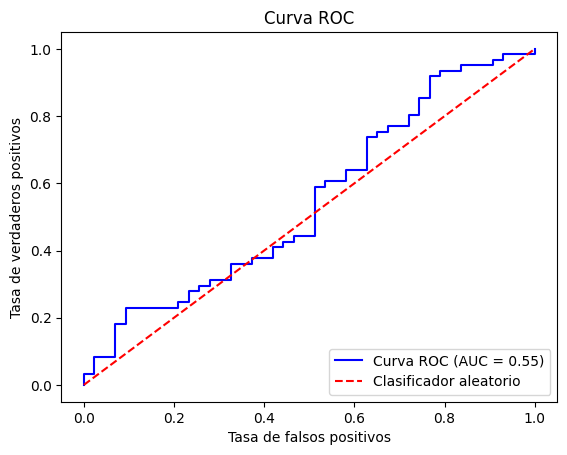

In [736]:
# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(test_y, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Clasificador aleatorio')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

#### LDA

In [737]:
lda = da.LinearDiscriminantAnalysis()
lda.fit(train_X_reshaped, train_y.values)

LinearDiscriminantAnalysis()

In [738]:
print('Intercepto:', lda.intercept_[0])
print('Coeficiente:', lda.coef_[0][0])
print('Prioridades:', lda.priors_)

Intercepto: 0.2034239991927851
Coeficiente: 0.05768451065437437
Prioridades: [0.44771574 0.55228426]


In [739]:
predicted_lda = lda.predict(test_X_reshaped)
predicted_prob_lda = lda.predict_proba(test_X_reshaped)[:, 1]

matrix_lda = confusion_matrix(test_y, predicted_lda).T
matrix_lda

array([[ 9,  5],
       [34, 56]], dtype=int64)

In [740]:
# imprimir las métricas
print('Accuracy:', round(accuracy_score(test_y, predicted_lda), 3))
print('AUC:', round(roc_auc_score(test_y, predicted_lda), 3))
print('Precision:', round(precision_score(test_y, predicted_lda), 3))
print('Recall:', round(recall_score(test_y, predicted_lda), 3))
print('Specificity:', round(matrix_lda[0][0] / matrix_lda.T[0].sum(), 3))

Accuracy: 0.625
AUC: 0.564
Precision: 0.622
Recall: 0.918
Specificity: 0.209


In [741]:
print(classification_report(test_y, predicted_lda, digits=3))

              precision    recall  f1-score   support

           0      0.643     0.209     0.316        43
           1      0.622     0.918     0.742        61

    accuracy                          0.625       104
   macro avg      0.633     0.564     0.529       104
weighted avg      0.631     0.625     0.566       104



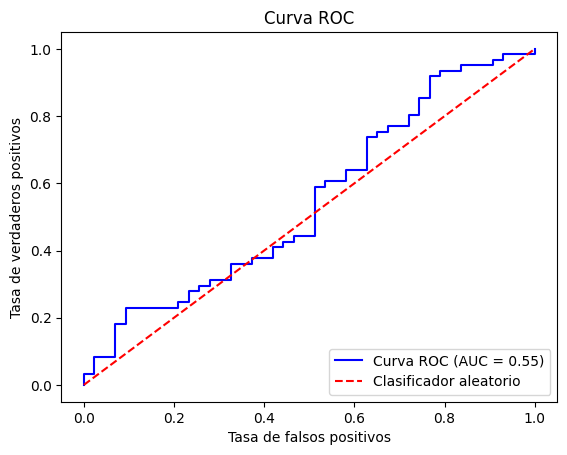

In [742]:
# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(test_y, predicted_prob_lda)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Clasificador aleatorio')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

#### QDA

In [743]:
qda = da.QuadraticDiscriminantAnalysis()
qda.fit(train_X_reshaped, train_y.values)

QuadraticDiscriminantAnalysis()

In [744]:
predicted_qda = qda.predict(test_X_reshaped)
predicted_prob_qda = qda.predict_proba(test_X_reshaped)[:, 1]

matrix_qda = confusion_matrix(test_y, predicted_qda).T
matrix_qda

array([[ 0,  0],
       [43, 61]], dtype=int64)

In [745]:
# imprimir las métricas
print('Accuracy:', round(accuracy_score(test_y, predicted_qda), 3))
print('AUC:', round(roc_auc_score(test_y, predicted_qda), 3))
print('Precision:', round(precision_score(test_y, predicted_qda), 3))
print('Recall:', round(recall_score(test_y, predicted_qda), 3))
print('Specificity:', round(matrix_qda[0][0] / matrix_qda.T[0].sum(), 3))

Accuracy: 0.587
AUC: 0.5
Precision: 0.587
Recall: 1.0
Specificity: 0.0


In [746]:
print(classification_report(test_y, predicted_qda, digits=3, zero_division=0))

              precision    recall  f1-score   support

           0      0.000     0.000     0.000        43
           1      0.587     1.000     0.739        61

    accuracy                          0.587       104
   macro avg      0.293     0.500     0.370       104
weighted avg      0.344     0.587     0.434       104



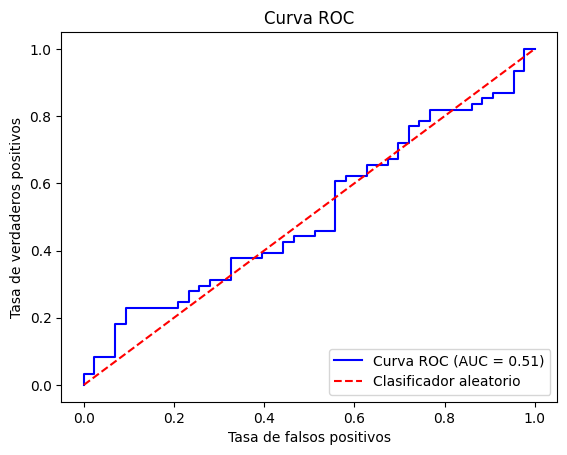

In [747]:
# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(test_y, predicted_prob_qda)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Clasificador aleatorio')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### KNN (k = 1)

In [748]:
knn_1 = nb.KNeighborsClassifier(n_neighbors=1)
knn_1.fit(train_X_reshaped, train_y.values)

KNeighborsClassifier(n_neighbors=1)

In [749]:
predicted_knn1 = knn_1.predict(test_X_reshaped)
predicted_prob_knn1 = knn_1.predict_proba(test_X_reshaped)[:, 1]

matrix_knn1 = confusion_matrix(test_y, predicted_knn1).T
matrix_knn1

array([[22, 30],
       [21, 31]], dtype=int64)

In [750]:
print('Accuracy:', round(accuracy_score(test_y, predicted_knn1), 3))
print('AUC:', round(roc_auc_score(test_y, predicted_knn1), 3))
print('Precision:', round(precision_score(test_y, predicted_knn1), 3))
print('Recall:', round(recall_score(test_y, predicted_knn1), 3))
print('Specificity:', round(matrix_knn1[0][0] / matrix_knn1.T[0].sum(), 3))

Accuracy: 0.51
AUC: 0.51
Precision: 0.596
Recall: 0.508
Specificity: 0.512


In [751]:
print(classification_report(test_y, predicted_knn1, digits=3))

              precision    recall  f1-score   support

           0      0.423     0.512     0.463        43
           1      0.596     0.508     0.549        61

    accuracy                          0.510       104
   macro avg      0.510     0.510     0.506       104
weighted avg      0.525     0.510     0.513       104



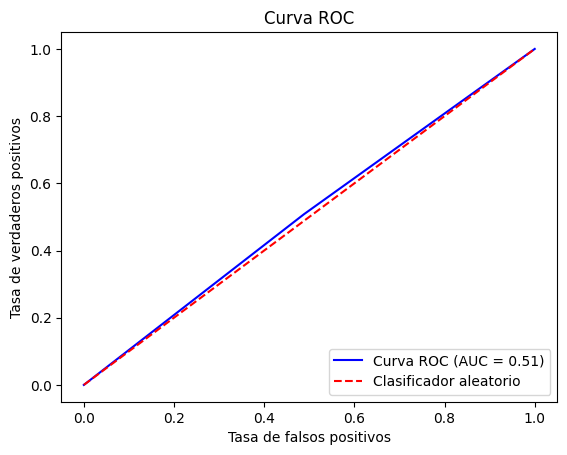

In [752]:
# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(test_y, predicted_prob_knn1)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Clasificador aleatorio')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### KNN (k = 9)

In [753]:
knn_9 = nb.KNeighborsClassifier(n_neighbors=9)
knn_9.fit(train_X_reshaped, train_y.values)

KNeighborsClassifier(n_neighbors=9)

In [754]:
predicted_knn9 = knn_9.predict(test_X_reshaped)
predicted_prob_knn9 = knn_9.predict_proba(test_X_reshaped)[:, 1]

matrix_knn3 = confusion_matrix(test_y, predicted_knn9).T
matrix_knn3

array([[17, 21],
       [26, 40]], dtype=int64)

In [755]:
print('Accuracy:', round(accuracy_score(test_y, predicted_knn9), 3))
print('AUC:', round(roc_auc_score(test_y, predicted_knn9), 3))
print('Precision:', round(precision_score(test_y, predicted_knn9), 3))
print('Recall:', round(recall_score(test_y, predicted_knn9), 3))
print('Specificity:', round(matrix_knn3[0][0] / matrix_knn3.T[0].sum(), 3))

Accuracy: 0.548
AUC: 0.526
Precision: 0.606
Recall: 0.656
Specificity: 0.395


In [756]:
print(classification_report(test_y, predicted_knn9, digits=3))

              precision    recall  f1-score   support

           0      0.447     0.395     0.420        43
           1      0.606     0.656     0.630        61

    accuracy                          0.548       104
   macro avg      0.527     0.526     0.525       104
weighted avg      0.540     0.548     0.543       104



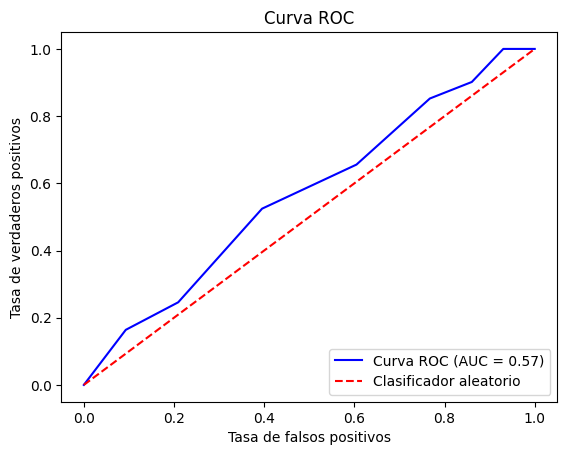

In [757]:
# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(test_y, predicted_prob_knn9)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Clasificador aleatorio')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### Experimentando con varios predictores

In [758]:
train_y = train['direction_dummy']
test_y = test['direction_dummy']

train['Lag1*Lag2'] = train['Lag1'] * train['Lag2']
test['Lag1*Lag2'] = test['Lag1'] * test['Lag2']

train['Lag2*Lag3'] = train['Lag2'] * train['Lag3']
test['Lag2*Lag3'] = test['Lag2'] * test['Lag3']

train['Lag1*Lag3'] = train['Lag1'] * train['Lag3']
test['Lag1*Lag3'] = test['Lag1'] * test['Lag3']

datasets = [
    {'name': 'Direction ~ Lag1', 'train': train[['Lag1']].values.reshape(-1, 1),
     'test': test[['Lag1']].values.reshape(-1, 1)},
    {'name': 'Direction ~ Lag1 + Lag2', 'train': train[['Lag1', 'Lag2']].values,
     'test': test[['Lag1', 'Lag2']].values},
    {'name': 'Direction ~ Lag2', 'train': train[['Lag2']].values.reshape(-1, 1),
     'test': test[['Lag2']].values.reshape(-1, 1)},
    {'name': 'Direction ~ Lag1 + Lag2 + Lag3', 'train': train[['Lag1', 'Lag2', 'Lag3']].values,
     'test': test[['Lag1', 'Lag2', 'Lag3']].values},
    {'name': 'Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5',
     'train': train[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5']].values,
     'test': test[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5']].values},
    {'name': 'Direction ~ Lag1 + Lag2 + Lag1*Lag2',
     'train': train[['Lag1', 'Lag2', 'Lag1*Lag2']].values,
     'test': test[['Lag1', 'Lag2', 'Lag1*Lag2']].values},
    {'name': 'Direction ~ Lag1 + Lag2 + Lag3 + Lag1*Lag2 + Lag2*Lag3',
     'train': train[['Lag1', 'Lag2', 'Lag3', 'Lag1*Lag2', 'Lag2*Lag3']].values,
     'test': test[['Lag1', 'Lag2', 'Lag3', 'Lag1*Lag2', 'Lag2*Lag3']].values}
]

C:\Users\orest\AppData\Local\Temp\ipykernel_14444\2048755213.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Lag1*Lag2'] = train['Lag1'] * train['Lag2']
C:\Users\orest\AppData\Local\Temp\ipykernel_14444\2048755213.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Lag1*Lag2'] = test['Lag1'] * test['Lag2']
C:\Users\orest\AppData\Local\Temp\ipykernel_14444\2048755213.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [759]:
# Definir los modelos
from sklearn.linear_model import LogisticRegression

models = [
    {'name': 'LR', 'model': LogisticRegression()},
    {'name': 'LDA', 'model': da.LinearDiscriminantAnalysis()},
    {'name': 'QDA', 'model': da.QuadraticDiscriminantAnalysis()},
    {'name': 'KNN k=1', 'model': nb.KNeighborsClassifier(n_neighbors=1)},
    {'name': 'KNN k=9', 'model': nb.KNeighborsClassifier(n_neighbors=9)},
    {'name': 'KNN k=15', 'model': nb.KNeighborsClassifier(n_neighbors=15)}
]

In [760]:
results = []
for dataset in datasets:
    df_metrics = pd.DataFrame()
    for model in models:
        model['model'].fit(dataset['train'], train_y.values)
        predicted_model = model['model'].predict(dataset['test'])
        matrix_model = confusion_matrix(test_y, predicted_model).T

        new_row = {
            'Accuracy': round(precision_score(test_y, predicted_model), 3),
            'AUC': round(roc_auc_score(test_y, predicted_model), 3),
            'Precision': round(precision_score(test_y, predicted_model), 3),
            'Recall': round(recall_score(test_y, predicted_model), 3),
            'Specificity': round(matrix_model[0][0] / matrix_model.T[0].sum(), 3)
        }
        df_metrics[model['name']] = new_row
    results.append({'name': dataset['name'], 'result': df_metrics})

for p in results:
    print(p['name'])
    print()
    print(p['result'])
    print('-------------')

Direction ~ Lag1

                LR    LDA    QDA  KNN k=1  KNN k=9  KNN k=15
Accuracy     0.585  0.585  0.587    0.544    0.577     0.566
AUC          0.497  0.497  0.500    0.452    0.487     0.469
Precision    0.585  0.585  0.587    0.544    0.577     0.566
Recall       0.902  0.902  1.000    0.508    0.672     0.705
Specificity  0.093  0.093  0.000    0.395    0.302     0.233
-------------
Direction ~ Lag1 + Lag2

                LR    LDA    QDA  KNN k=1  KNN k=9  KNN k=15
Accuracy     0.596  0.596  0.586    0.561    0.603     0.639
AUC          0.516  0.516  0.499    0.472    0.521     0.564
Precision    0.596  0.596  0.586    0.561    0.603     0.639
Recall       0.869  0.869  0.836    0.525    0.623     0.639
Specificity  0.163  0.163  0.163    0.419    0.419     0.488
-------------
Direction ~ Lag2

                LR    LDA    QDA  KNN k=1  KNN k=9  KNN k=15
Accuracy     0.622  0.622  0.587    0.596    0.606     0.641
AUC          0.564  0.564  0.500    0.510    0.526     0.

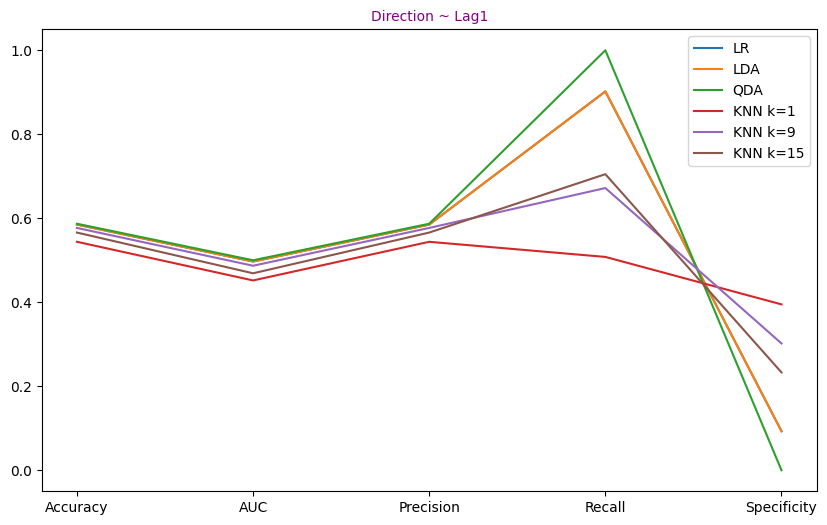

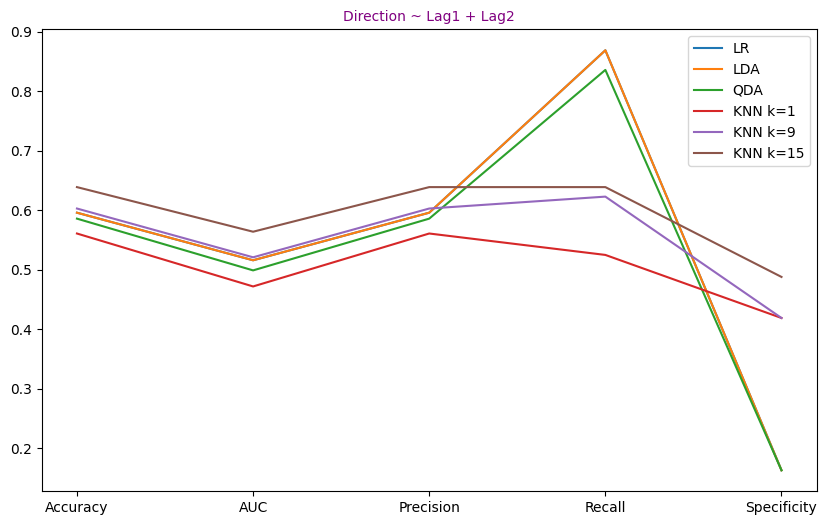

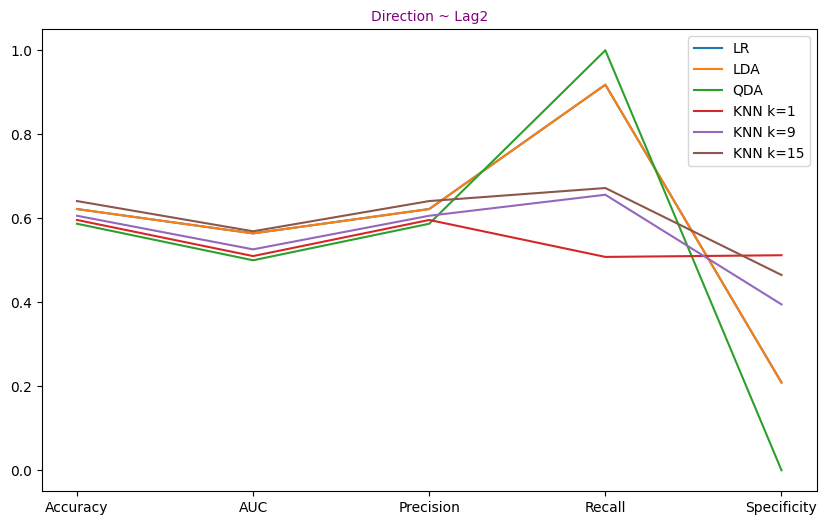

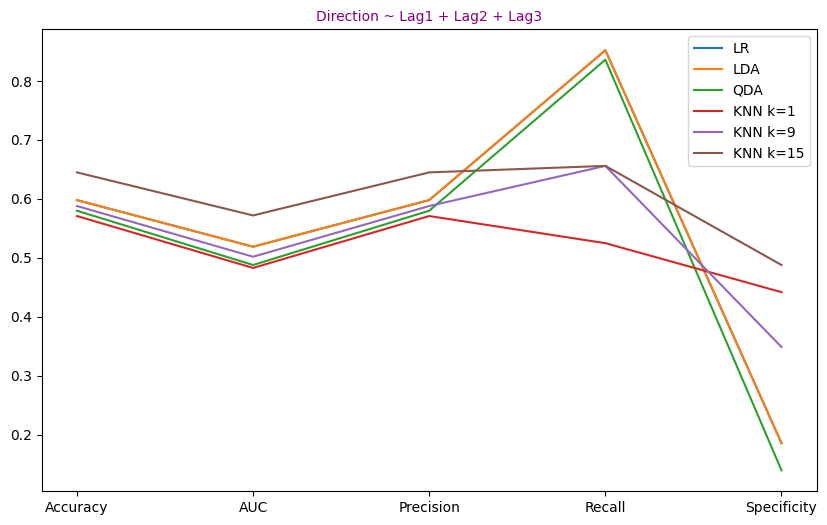

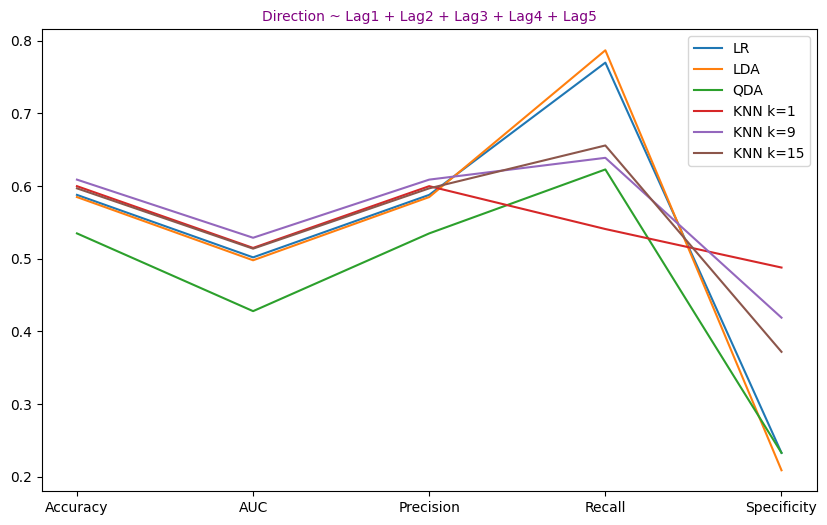

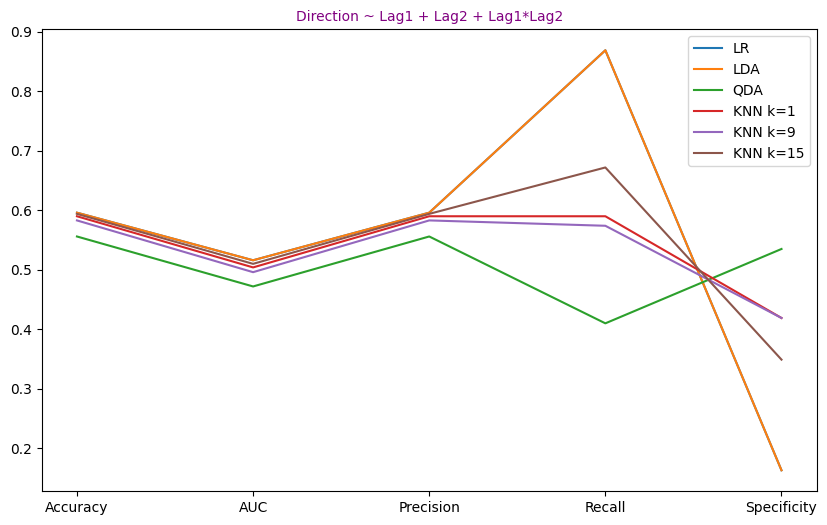

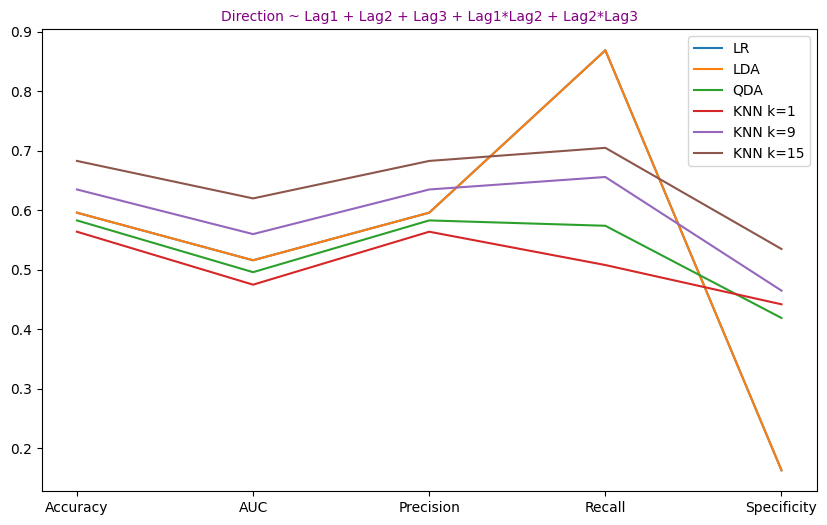

In [761]:
for result in results:
    fig = plt.figure(figsize=(10, 6))
    for column_name in result['result'].columns:
        plt.plot(result['result'][column_name], label=column_name)

    plt.legend()
    plt.title(result['name'], size=10, color="purple")
    plt.show()

Como se puede apreciar de manera general todos los modelos tienen unos valores de exactitud, presición y AUC similares.
- Donde existe una mayor diferencia es entre los valores de sensibilidad y especificidad.
- Los modelos: LR, LDA y QDA suelen tener un mayor valor de sensibilidad (recall), sacrificando en su lugar la especificidad (valores muy bajos).
- El clasificador KNN posee un mejor balance entre especificidad y sensibilidad.

El modelo que obtuvo los mejores resultados fue **KNN k= 15** (Direction ~ Lag1 + Lag2 + Lag3 + Lag1-Lag2 + Lag2-Lag3)
- Obtuvo los mejores valores en las métricas: exactidud, presición y AUC.
- Es el modelo que logró un mejor balance entre especificidad(*0.535*) y sensibilidad (*0.705*).

In [762]:
X_train15 = pd.DataFrame()
X_test15 = pd.DataFrame()

for dataset in datasets:
    if dataset['name'] == 'Direction ~ Lag1 + Lag2 + Lag3 + Lag1*Lag2 + Lag2*Lag3':
        X_train15 = dataset['train']
        X_test15 = dataset['test']

y_train = train_y.values
y_test = test_y

knn_15 = nb.KNeighborsClassifier(n_neighbors=15)
knn_15.fit(X_train15, y_train)

KNeighborsClassifier(n_neighbors=15)

In [763]:
predicted_knn15 = knn_15.predict(X_test15)
predicted_prob_knn15 = knn_15.predict_proba(X_test15)[:, 1]

matrix_knn15 = confusion_matrix(y_test, predicted_knn15).T
matrix_knn15

array([[23, 18],
       [20, 43]], dtype=int64)

In [764]:
# imprimir las métricas
print('Accuracy:', round(accuracy_score(y_test, predicted_knn15), 3))
print('AUC:', round(roc_auc_score(y_test, predicted_knn15), 3))
print('Precision:', round(precision_score(y_test, predicted_knn15), 3))
print('Recall:', round(recall_score(y_test, predicted_knn15), 3))
print('Specificity:', round(matrix_knn15[0][0] / matrix_knn15.T[0].sum(), 3))

Accuracy: 0.635
AUC: 0.62
Precision: 0.683
Recall: 0.705
Specificity: 0.535


In [765]:
print(classification_report(y_test, predicted_knn15, digits=3, zero_division=0))

              precision    recall  f1-score   support

           0      0.561     0.535     0.548        43
           1      0.683     0.705     0.694        61

    accuracy                          0.635       104
   macro avg      0.622     0.620     0.621       104
weighted avg      0.632     0.635     0.633       104



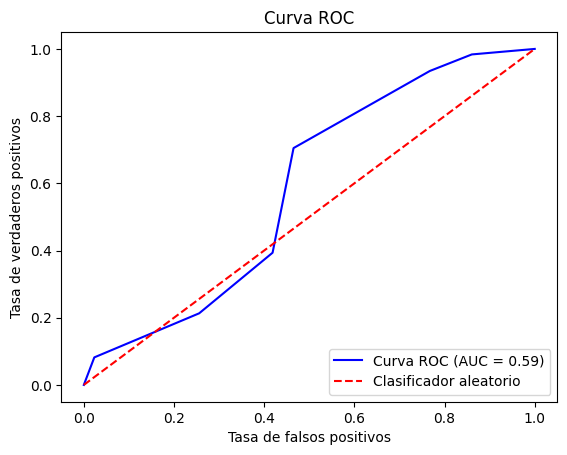

In [766]:
# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, predicted_prob_knn15)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Clasificador aleatorio')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()